In [1]:
import pandas as pd
import datetime as dt

In [2]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df=df.drop(['Unnamed: 0'], axis=1)

## Analisi 1 ristorante

In [5]:
df=df[['date','scontr_medio1']]

### Visualize time series

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

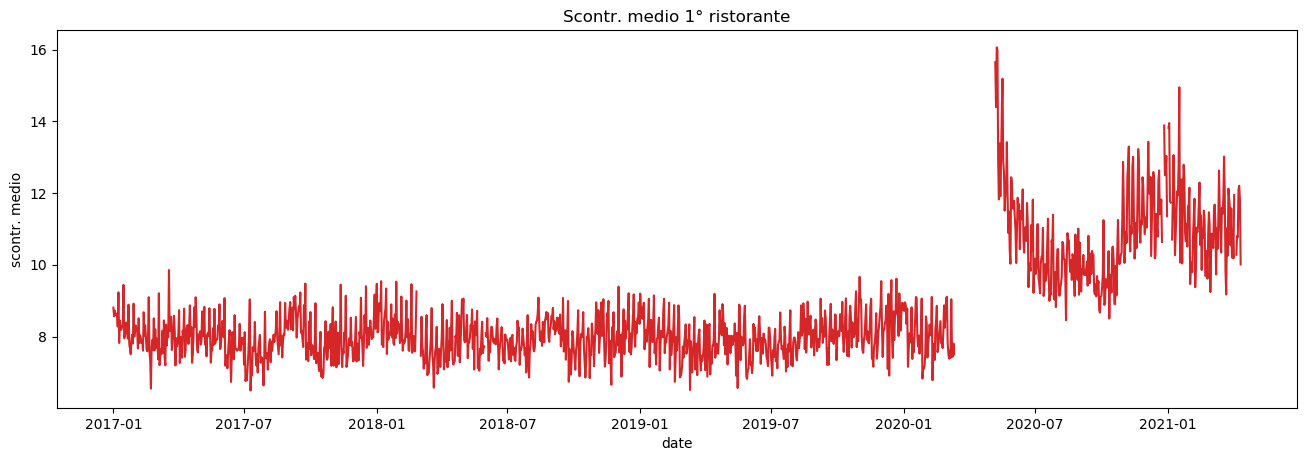

In [10]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='date', ylabel='scontr. medio', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.date, y=df.scontr_medio1, title='Scontr. medio 1° ristorante')     

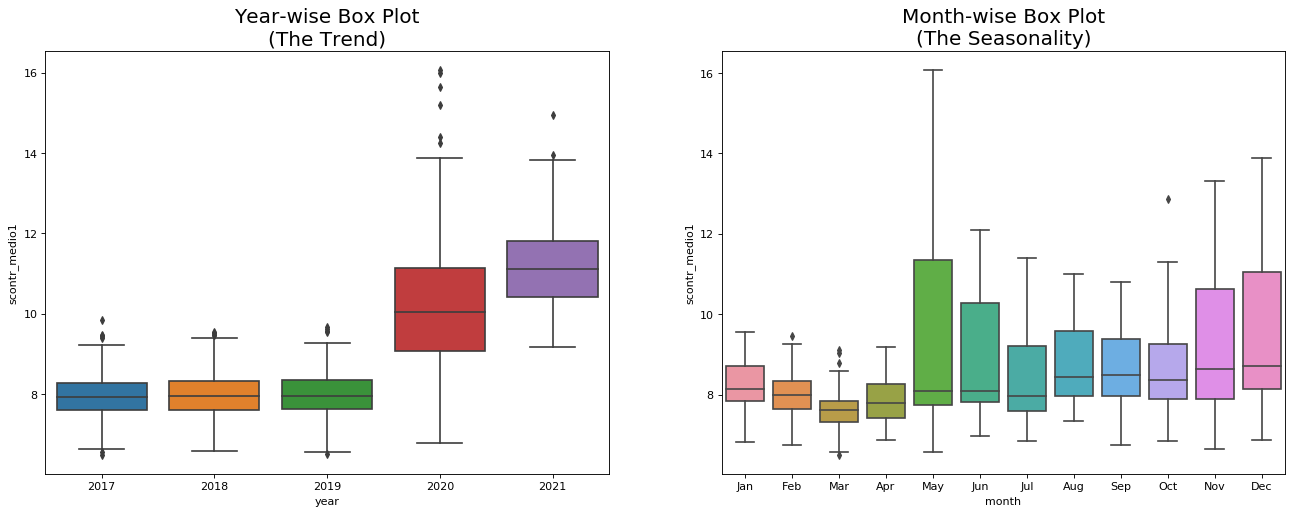

In [13]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio1', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio1', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Elimino i valori nulli per evitare alterazioni

In [7]:
df=df.dropna(subset=['scontr_medio1'])
df=df.reset_index()
df=df[['date','scontr_medio1']]

In [8]:
tra = df[:1379]
tes = df[1379:]

#### Overview data

In [9]:
import matplotlib.pyplot as plt

In [18]:
tra=tra.set_index(['date'])

C:\Users\marta\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

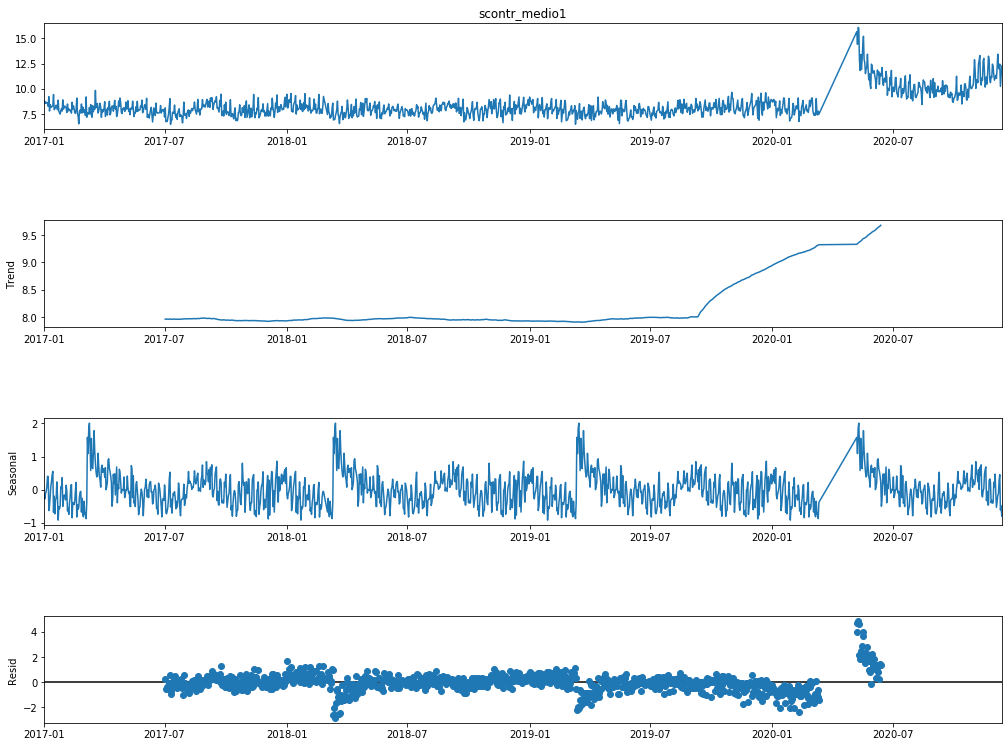

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tra['scontr_medio1'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

### Studio Stazionarietà

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

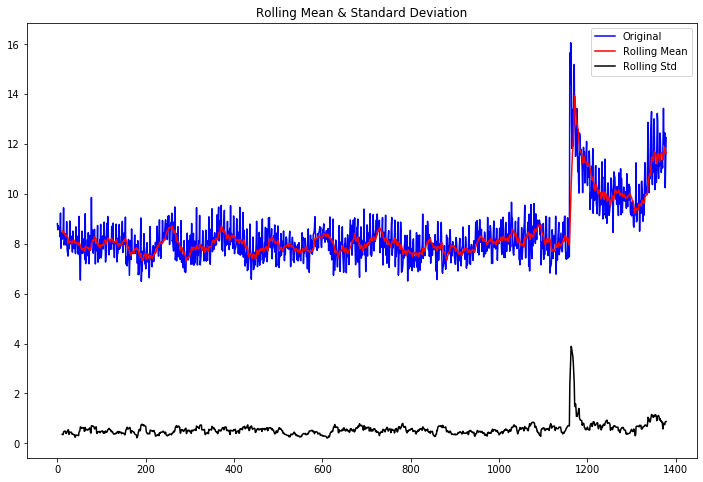

Results of Dickey-Fuller Test:
p-value = 0.6273. The series is likely non-stationary.
Test Statistic                   -1.304175
p-value                           0.627260
#Lags Used                       20.000000
Number of Observations Used    1358.000000
Critical Value (1%)              -3.435175
Critical Value (5%)              -2.863671
Critical Value (10%)             -2.567904
dtype: float64


In [19]:
test_stationarity(tra['scontr_medio1'])

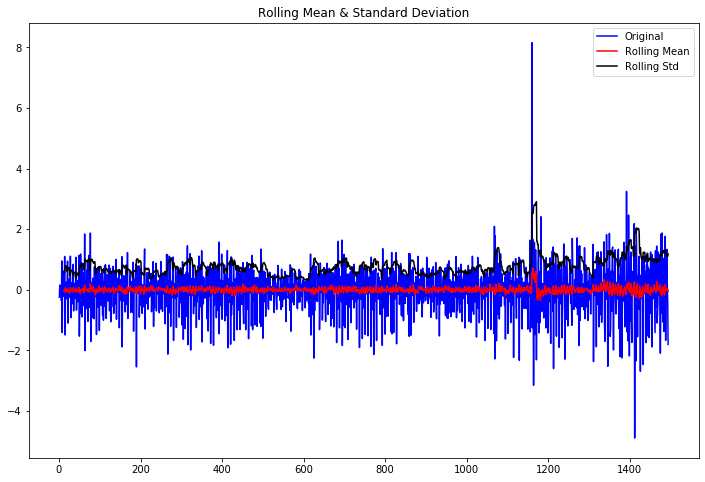

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.114067e+01
p-value                        3.114099e-20
#Lags Used                     2.000000e+01
Number of Observations Used    1.473000e+03
Critical Value (1%)           -3.434797e+00
Critical Value (5%)           -2.863504e+00
Critical Value (10%)          -2.567816e+00
dtype: float64


In [20]:
first_diff = df.scontr_medio1 - df.scontr_medio1.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

### ACF and PACF

In [10]:
import statsmodels.api as sm

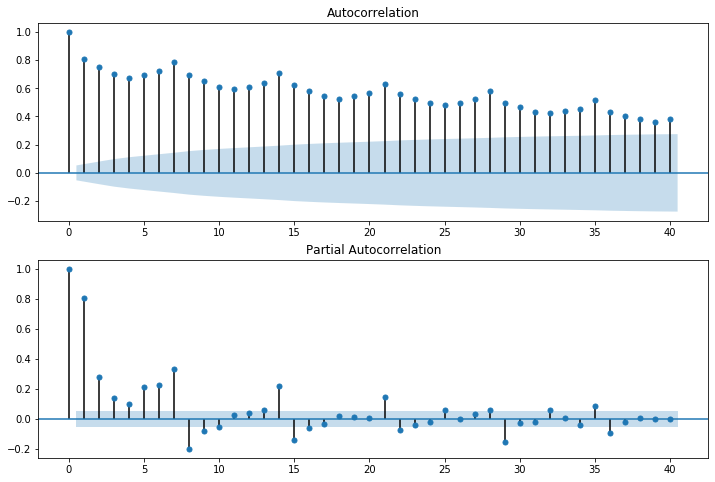

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tra.scontr_medio1, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tra.scontr_medio1, lags=40, ax=ax2)# , lags=40

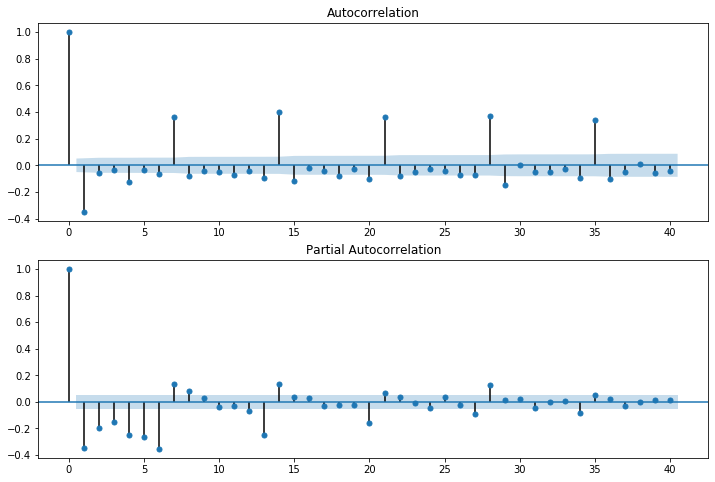

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

There are significant positive spike in the ACF plot at lag 1 and 7. In the PACF plot there are significant positive at lags 1 and 2, as well as significant positive spikes at 7, 14, 21. These charateristics suggest a potential parameter starting point of SARIMA (1,1,1) (1,1,0,7) S is equal to 7 due to weekly seasonal component

### Consider seasonality affect by SARIMA

I find the optimal hyperparameters

In [9]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = range(7,8)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tra.scontr_medio1,
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 3.382593
         Iterations: 2
         Function evaluations: 62
SARIMA(0, 0, 0),(0, 0, 0, 7) - AIC:9331.192100421336
Optimization terminated successfully.
         Current function value: 2.796032
         Iterations: 3
         Function evaluations: 80
SARIMA(0, 0, 0),(0, 0, 1, 7) - AIC:7715.454877818365
Optimization terminated successfully.
         Current function value: 2.342226
         Iterations: 5
         Function evaluations: 197
SARIMA(0, 0, 0),(0, 0, 2, 7) - AIC:6465.858519830197
Optimization terminated successfully.
         Current function value: 0.895499
         Iterations: 2
         Function evaluations: 68
SARIMA(0, 0, 0),(0, 1, 0, 7) - AIC:2471.785940118259
Optimization terminated successfully.
         Current function value: 0.840374
         Iterations: 2
         Function evaluations: 62
SARIMA(0, 0, 0),(0, 1, 1, 7) - AIC:2321.7519166883476
Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: 0.770902
         Iterations: 6
         Function evaluations: 381
SARIMA(0, 0, 2),(1, 0, 1, 7) - AIC:2136.148119376716
Optimization terminated successfully.
         Current function value: 0.770876
         Iterations: 6
         Function evaluations: 447
SARIMA(0, 0, 2),(1, 0, 2, 7) - AIC:2138.076008288604
Optimization terminated successfully.
         Current function value: 0.779217
         Iterations: 3
         Function evaluations: 168
SARIMA(0, 0, 2),(1, 1, 0, 7) - AIC:2157.079355207653
Optimization terminated successfully.
         Current function value: 0.755136
         Iterations: 4
         Function evaluations: 251
SARIMA(0, 0, 2),(1, 1, 1, 7) - AIC:2092.6641914464717
Optimization terminated successfully.
         Current function value: 0.755073
         Iterations: 3
         Function evaluations: 224
SARIMA(0, 0, 2),(1, 1, 2, 7) - AIC:2094.4921150928185
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 0.625297
         Iterations: 7
         Function evaluations: 529
SARIMA(0, 1, 1),(2, 0, 2, 7) - AIC:1736.570446581739
Optimization terminated successfully.
         Current function value: 0.724114
         Iterations: 2
         Function evaluations: 107
SARIMA(0, 1, 1),(2, 1, 0, 7) - AIC:2005.1064594849918
Optimization terminated successfully.
         Current function value: 0.619536
         Iterations: 7
         Function evaluations: 459
SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:1718.6796788952952
Optimization terminated successfully.
         Current function value: 0.618704
         Iterations: 4
         Function evaluations: 298
SARIMA(0, 1, 1),(2, 1, 2, 7) - AIC:1718.3843885553915
Optimization terminated successfully.
         Current function value: 0.856382
         Iterations: 2
         Function evaluations: 75
SARIMA(0, 1, 2),(0, 0, 0, 7) - AIC:2367.9024314431676
Optimization terminated successfully.
    

Optimization terminated successfully.
         Current function value: 0.849229
         Iterations: 2
         Function evaluations: 89
SARIMA(1, 0, 1),(0, 1, 0, 7) - AIC:2348.1731772442527
Optimization terminated successfully.
         Current function value: 0.619060
         Iterations: 6
         Function evaluations: 306
SARIMA(1, 0, 1),(0, 1, 1, 7) - AIC:1715.3668457143006
Optimization terminated successfully.
         Current function value: 0.616934
         Iterations: 6
         Function evaluations: 367
SARIMA(1, 0, 1),(0, 1, 2, 7) - AIC:1711.504387774803
Optimization terminated successfully.
         Current function value: 0.862475
         Iterations: 3
         Function evaluations: 162
SARIMA(1, 0, 1),(1, 0, 0, 7) - AIC:2386.707424261299
Optimization terminated successfully.
         Current function value: 0.624659
         Iterations: 8
         Function evaluations: 518
SARIMA(1, 0, 1),(1, 0, 1, 7) - AIC:1732.8087161979488
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 0.690511
         Iterations: 4
         Function evaluations: 215
SARIMA(1, 1, 0),(1, 1, 1, 7) - AIC:1912.4305851665565
Optimization terminated successfully.
         Current function value: 0.691750
         Iterations: 3
         Function evaluations: 194
SARIMA(1, 1, 0),(1, 1, 2, 7) - AIC:1917.84626060342
Optimization terminated successfully.
         Current function value: 0.788034
         Iterations: 2
         Function evaluations: 105
SARIMA(1, 1, 0),(2, 0, 0, 7) - AIC:2181.39750869091
Optimization terminated successfully.
         Current function value: 0.693707
         Iterations: 7
         Function evaluations: 459
SARIMA(1, 1, 0),(2, 0, 1, 7) - AIC:1923.2437919655017
Optimization terminated successfully.
         Current function value: 0.695192
         Iterations: 6
         Function evaluations: 462
SARIMA(1, 1, 0),(2, 0, 2, 7) - AIC:1929.338547953641
Optimization terminated successfully.
       

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.851174
         Iterations: 14
         Function evaluations: 733
SARIMA(1, 1, 2),(0, 1, 0, 7) - AIC:2355.537057907907
Optimization terminated successfully.
         Current function value: 0.621301
         Iterations: 3
         Function evaluations: 208
SARIMA(1, 1, 2),(0, 1, 1, 7) - AIC:1723.5474032344246
Optimization terminated successfully.
         Current function value: 0.619258
         Iterations: 3
         Function evaluations: 218
SARIMA(1, 1, 2),(0, 1, 2, 7) - AIC:1719.9143564414435
Optimization terminated successfully.
         Current function value: 0.737193
         Iterations: 10
         Function evaluations: 665
SARIMA(1, 1, 2),(1, 0, 0, 7) - AIC:2043.1772096320842
Optimization terminated successfully.
         Current function value: 0.623799
         Iterations: 7
         Function evaluations: 524
SARIMA(1, 1, 2),(1, 0, 1, 7) - AIC:1732.4367327914815
Optimization terminated successfully.
 

Optimization terminated successfully.
         Current function value: 0.615085
         Iterations: 5
         Function evaluations: 366
SARIMA(2, 0, 1),(1, 1, 1, 7) - AIC:1708.4050086667387
Optimization terminated successfully.
         Current function value: 0.616189
         Iterations: 6
         Function evaluations: 512
SARIMA(2, 0, 1),(1, 1, 2, 7) - AIC:1713.4487606207554
Optimization terminated successfully.
         Current function value: 0.701141
         Iterations: 21
         Function evaluations: 1608
SARIMA(2, 0, 1),(2, 0, 0, 7) - AIC:1945.7463865527982
Optimization terminated successfully.
         Current function value: 0.621178
         Iterations: 8
         Function evaluations: 689
SARIMA(2, 0, 1),(2, 0, 1, 7) - AIC:1727.2094729764103
Optimization terminated successfully.
         Current function value: 0.622713
         Iterations: 10
         Function evaluations: 993
SARIMA(2, 0, 1),(2, 0, 2, 7) - AIC:1733.442626217629
Optimization terminated successfully.


Optimization terminated successfully.
         Current function value: 0.652319
         Iterations: 4
         Function evaluations: 353
SARIMA(2, 1, 0),(2, 1, 2, 7) - AIC:1813.0956997626913
Optimization terminated successfully.
         Current function value: 0.855989
         Iterations: 2
         Function evaluations: 98
SARIMA(2, 1, 1),(0, 0, 0, 7) - AIC:2368.8182684054977
Optimization terminated successfully.
         Current function value: 0.784937
         Iterations: 3
         Function evaluations: 188
SARIMA(2, 1, 1),(0, 0, 1, 7) - AIC:2174.8561078471766
Optimization terminated successfully.
         Current function value: 0.746358
         Iterations: 4
         Function evaluations: 298
SARIMA(2, 1, 1),(0, 0, 2, 7) - AIC:2070.4552606149964
Optimization terminated successfully.
         Current function value: 0.854822
         Iterations: 8
         Function evaluations: 436
SARIMA(2, 1, 1),(0, 1, 0, 7) - AIC:2365.599678546248
Optimization terminated successfully.
    

I choose the combination with the lowest AIC value which is SARIMA(2, 0, 1),(2, 1, 1, 7) - AIC:1707.52

In [13]:
mod = sm.tsa.statespace.SARIMAX(tra.scontr_medio1,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0697      0.032     33.046      0.000       1.006       1.133
ar.L2         -0.1215      0.026     -4.697      0.000      -0.172      -0.071
ma.L1         -0.6359      0.027    -23.977      0.000      -0.688      -0.584
ar.S.L7        0.0478      0.024      1.977      0.048       0.000       0.095
ar.S.L14       0.0350      0.030      1.186      0.236      -0.023       0.093
ma.S.L7       -0.8961      0.018    -50.755      0.000      -0.931      -0.862
sigma2         0.2984      0.003    109.224      0.000       0.293       0.304


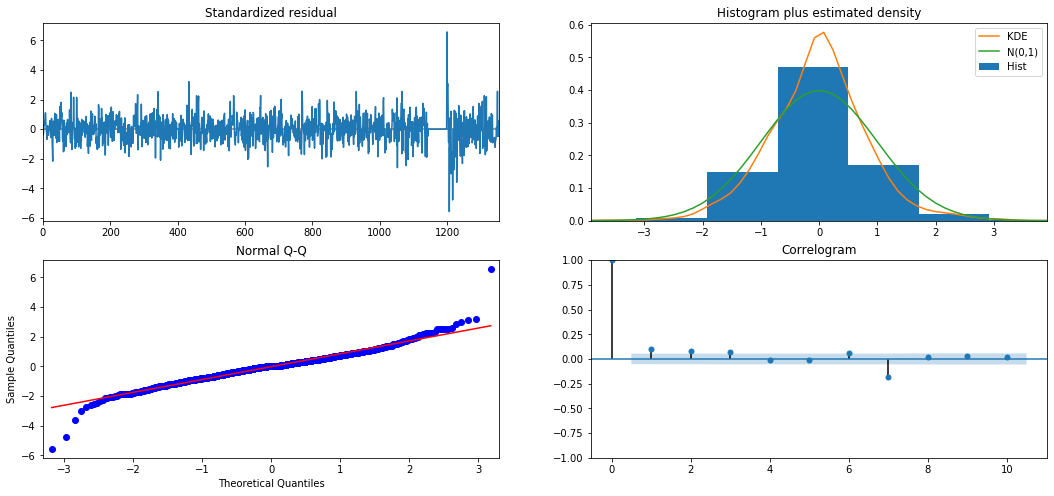

In [11]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()
#vedo come si comporta il modello 

From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals

### Make prediction and evaluation

In [14]:
start_index1=1379
end_index1=1494
tes['forecast'] = results.predict(start = start_index1, end=end_index1, dynamic= True)  

C:\Users\marta\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
tes=tes.set_index(['date'])

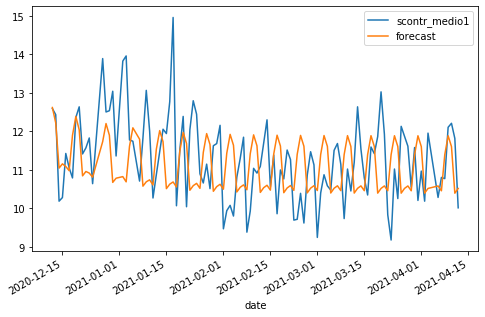

In [17]:
tes[['scontr_medio1', 'forecast']].plot(figsize=(8, 5))

In [15]:
import numpy as np

In [16]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [17]:
smape_kun(tes['scontr_medio1'],tes['forecast'])

MAPE: 15.82 % 
SMAPE: 16.90 %


Good MAPE

## Analisi 2° ristorante

In [73]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df['date'] = pd.to_datetime(df['date'])
df=df.drop(['Unnamed: 0'], axis=1)
df=df[['date','scontr_medio2']]

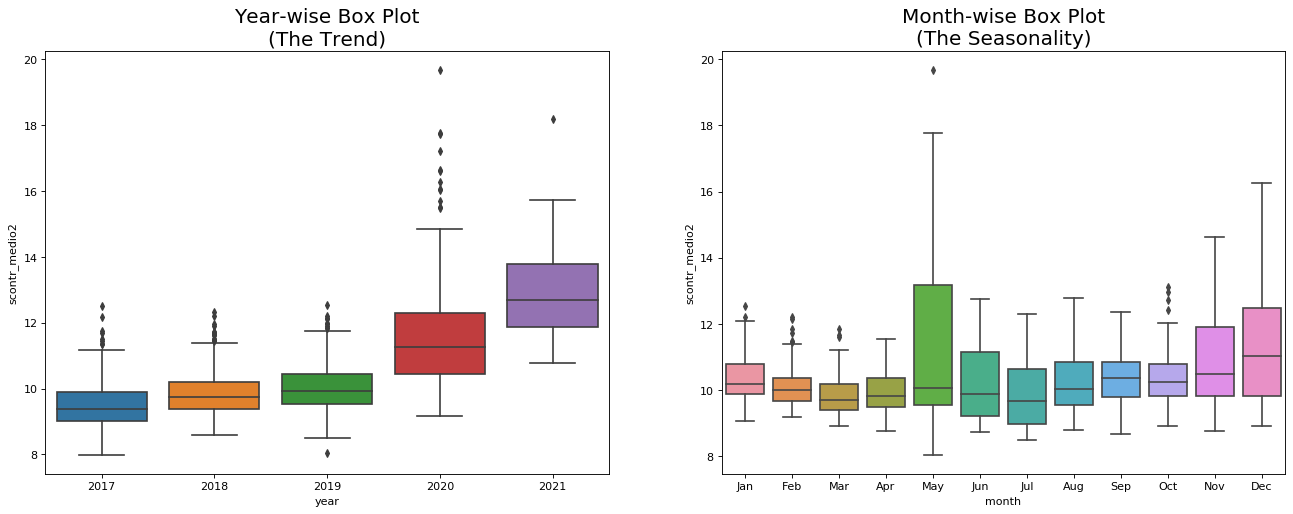

In [76]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio2', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio2', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Analisi 3 Ristorante

In [78]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df['date'] = pd.to_datetime(df['date'])
df=df.drop(['Unnamed: 0'], axis=1)
df=df[['date','scontr_medio3']]

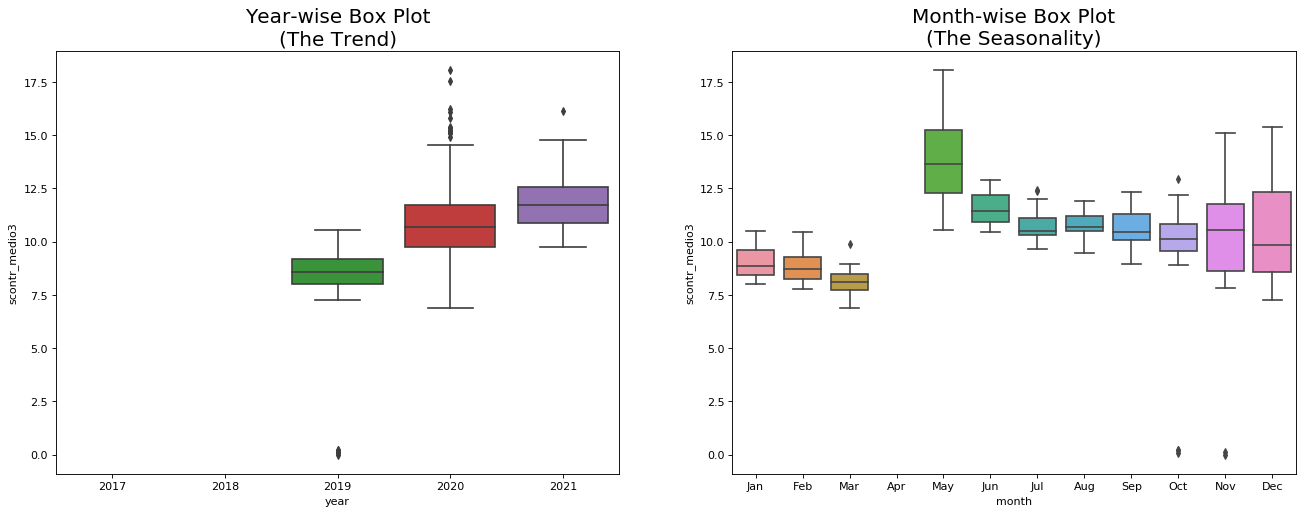

In [81]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio3', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio3', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Analisi 4 ristorate

In [82]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df['date'] = pd.to_datetime(df['date'])
df=df.drop(['Unnamed: 0'], axis=1)
df=df[['date','scontr_medio4']]

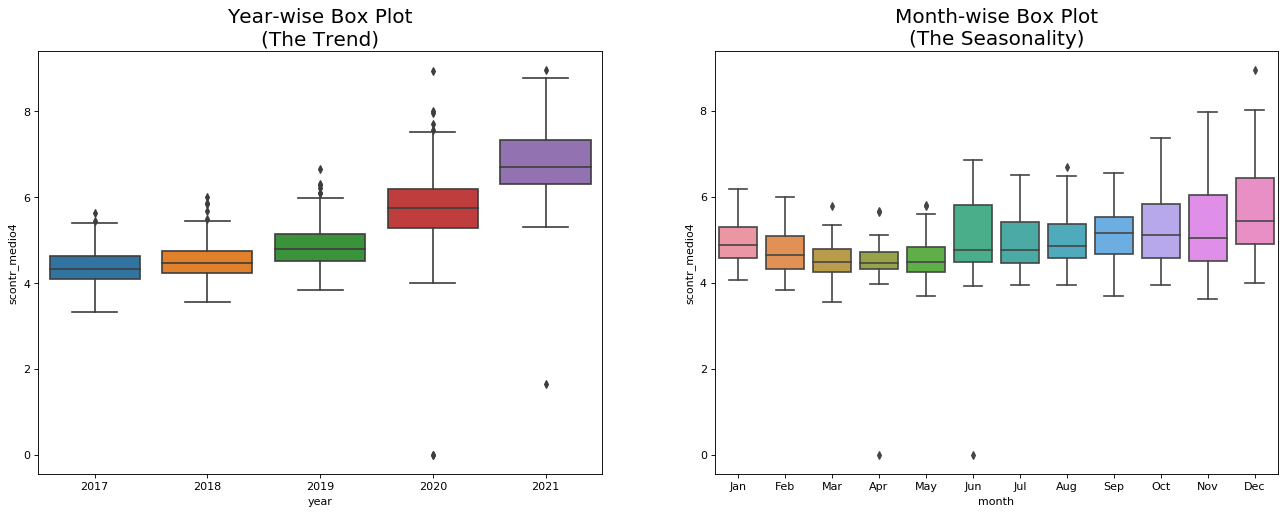

In [83]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio4', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio4', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Analisi 5 ristorante

In [84]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df['date'] = pd.to_datetime(df['date'])
df=df.drop(['Unnamed: 0'], axis=1)
df=df[['date','scontr_medio5']]

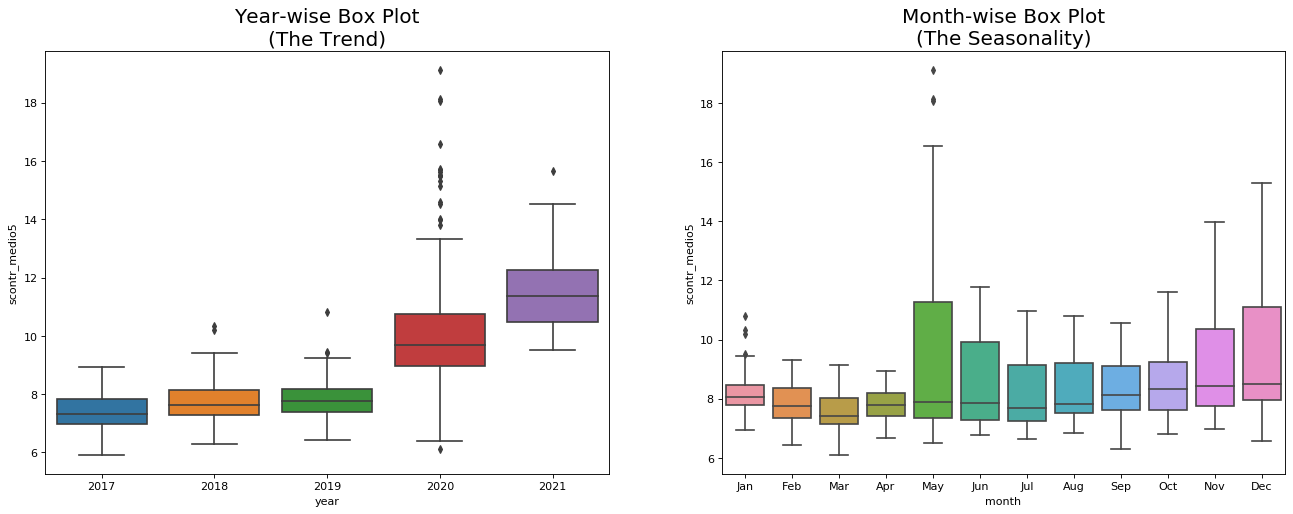

In [85]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio5', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio5', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Analisi 6 ristorante

In [86]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df['date'] = pd.to_datetime(df['date'])
df=df.drop(['Unnamed: 0'], axis=1)
df=df[['date','scontr_medio6']]

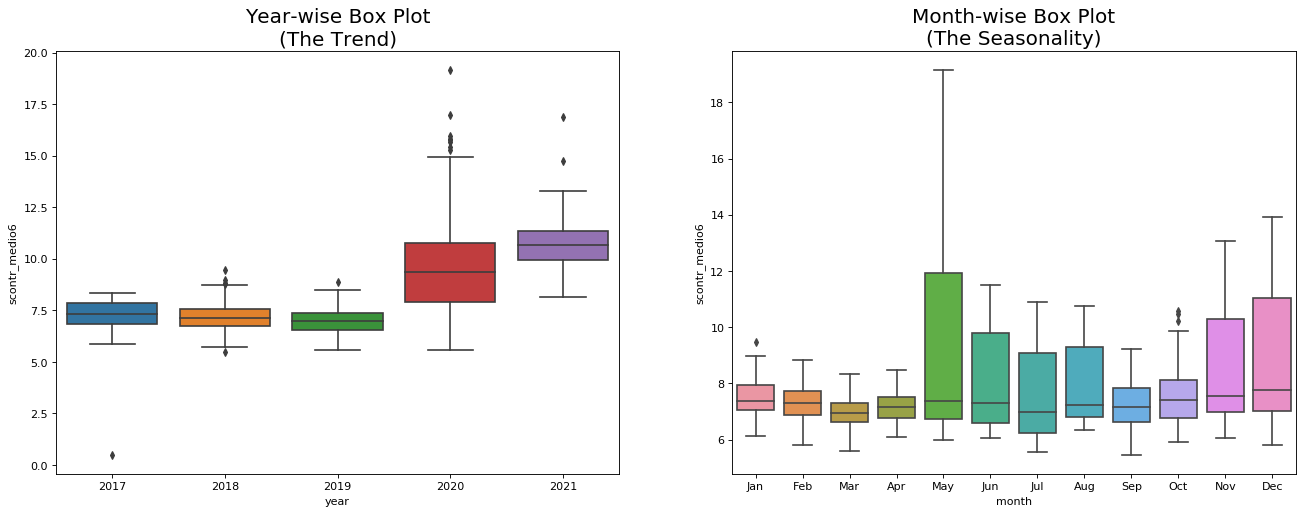

In [87]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='scontr_medio6', data=df, ax=axes[0])
sns.boxplot(x='month', y='scontr_medio6', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### SARIMAX: adding external variables

In [3]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')

In [4]:
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio1','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio1'])

In [5]:
df.index = df.date

In [6]:
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

In [23]:
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])

In [24]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio1,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.017e-06   1.95e+04  -5.21e-11      1.000   -3.83e+04    3.83e+04
temp_media     0.0007      0.006      0.121      0.904      -0.011       0.013
ar.L1          0.9793      0.037     26.710      0.000       0.907       1.051
ar.L2         -0.0545      0.027     -1.983      0.047      -0.108      -0.001
ma.L1         -0.5691      0.032    -18.037      0.000      -0.631      -0.507
ar.S.L7        0.0930      0.026      3.630      0.000       0.043       0.143
ar.S.L14       0.0624      0.030      2.072      0.038       0.003       0.121
ma.S.L7       -0.8809      0.019    -45.766      0.000      -0.919      -0.843
sigma2         0.3275      0.007     49.497      0.000       0.315       0.340


La variabile temperatura media non risulta significativa.

In [7]:
tra['is_weekend']=tra['is_weekend'].astype(float)

In [8]:
tra['is_holiday']=tra['is_holiday'].astype(float)

In [9]:
uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

In [10]:
due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

In [11]:
fuso=uno.merge(due,on='date')

In [12]:
exog=fuso

In [15]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio1,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     0.5767      0.063      9.127      0.000       0.453       0.701
is_holiday     0.4218      0.079      5.358      0.000       0.267       0.576
ar.L1          0.7659     12.223      0.063      0.950     -23.191      24.723
ar.L2          0.1654     11.503      0.014      0.989     -22.381      22.711
ma.L1         -0.3655     12.222     -0.030      0.976     -24.320      23.589
ma.L2         -0.0966      6.612     -0.015      0.988     -13.056      12.863
ar.S.L7        0.0724      0.025      2.945      0.003       0.024       0.121
ar.S.L14       0.0434      0.030      1.426      0.154      -0.016       0.103
ma.S.L7       -0.9348      0.014    -65.199      0.000      -0.963      -0.907
sigma2         0.3005      0.003    103.263      0.000       0.295       0.306


In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

## Variabili esterne per altri ristoranti

In [20]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')

In [21]:
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio2','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio2'])

In [22]:
df.index = df.date

### temp media per altri ristoranti

In [23]:
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

In [24]:
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])

In [26]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio2,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.594e-07   2.31e+04  -1.55e-11      1.000   -4.53e+04    4.53e+04
temp_media    -0.0019      0.007     -0.270      0.787      -0.016       0.012
ar.L1          1.0380      0.047     22.245      0.000       0.947       1.129
ar.L2         -0.1297      0.034     -3.817      0.000      -0.196      -0.063
ma.L1         -0.5920      0.041    -14.581      0.000      -0.672      -0.512
ar.S.L7        0.0883      0.033      2.678      0.007       0.024       0.153
ar.S.L14       0.0527      0.024      2.208      0.027       0.006       0.099
ma.S.L7       -0.7779      0.032    -24.388      0.000      -0.840      -0.715
sigma2         0.3771      0.006     58.330      0.000       0.364       0.390


La variabile temperatura media non risulta significativa per il secondo ristorante.

In [29]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio3','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio3'])
df.index = df.date
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio3,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.121e-05   1.95e-09  -5756.198      0.000   -1.12e-05   -1.12e-05
temp_media     0.0209      0.013      1.627      0.104      -0.004       0.046
ar.L1          1.0862      0.171      6.369      0.000       0.752       1.420
ar.L2         -0.1788      0.131     -1.367      0.172      -0.435       0.078
ma.L1         -0.4751      0.160     -2.974      0.003      -0.788      -0.162
ar.S.L7       -0.0125      0.071     -0.177      0.859      -0.151       0.126
ar.S.L14    9.478e-06      0.058      0.000      1.000      -0.114       0.114
ma.S.L7       -0.7544      0.055    -13.624      0.000      -0.863      -0.646
sigma2         0.7619      0.031     24.233      0.000       0.700       0.823


In [32]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio4','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio4'])
df.index = df.date
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio4,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.822e-07    6.5e-10    280.440      0.000    1.81e-07    1.83e-07
temp_media    -0.0102      0.003     -3.621      0.000      -0.016      -0.005
ar.L1         -0.5900      0.020    -29.726      0.000      -0.629      -0.551
ar.L2          0.3713      0.011     33.310      0.000       0.349       0.393
ma.L1          0.9215      0.022     42.324      0.000       0.879       0.964
ar.S.L7        0.1320      0.026      5.162      0.000       0.082       0.182
ar.S.L14   -3.537e-06      0.026     -0.000      1.000      -0.051       0.051
ma.S.L7       -0.8037      0.027    -30.221      0.000      -0.856      -0.752
sigma2         0.2238      0.004     62.784      0.000       0.217       0.231


In [33]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio5','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio5'])
df.index = df.date
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio5,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.88e-07   1.06e-09   -176.915      0.000    -1.9e-07   -1.86e-07
temp_media     0.0043      0.008      0.550      0.582      -0.011       0.019
ar.L1          1.1426      0.056     20.398      0.000       1.033       1.252
ar.L2         -0.2175      0.042     -5.203      0.000      -0.299      -0.136
ma.L1         -0.6059      0.054    -11.259      0.000      -0.711      -0.500
ar.S.L7        0.1511      0.021      7.069      0.000       0.109       0.193
ar.S.L14    -1.61e-05      0.016     -0.001      0.999      -0.031       0.031
ma.S.L7       -0.8592      0.019    -45.096      0.000      -0.897      -0.822
sigma2         0.4431      0.007     66.449      0.000       0.430       0.456


In [35]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio6','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio6'])
df.index = df.date
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])
exog = sm.add_constant(tra.loc[:'2021-12-11', 'temp_media'])
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio6,exog,
                                order=(2, 0, 1),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.606e-07   1.39e+04   3.32e-11      1.000   -2.72e+04    2.72e+04
temp_media     0.0155      0.009      1.820      0.069      -0.001       0.032
ar.L1          1.0331      0.043     23.968      0.000       0.949       1.118
ar.L2         -0.0959      0.035     -2.703      0.007      -0.166      -0.026
ma.L1         -0.5552      0.041    -13.422      0.000      -0.636      -0.474
ar.S.L7        0.0675      0.020      3.440      0.001       0.029       0.106
ar.S.L14       0.0379      0.020      1.890      0.059      -0.001       0.077
ma.S.L7       -0.8295      0.019    -42.973      0.000      -0.867      -0.792
sigma2         0.5305      0.008     64.812      0.000       0.514       0.547


### 'is_weekend','is_holiday' per altri ristoranti

2 modello

In [52]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')

In [53]:
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio2','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio2'])

In [54]:
df.index = df.date

In [55]:
tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

In [56]:
tra['is_weekend']=tra['is_weekend'].astype(float)
tra['is_holiday']=tra['is_holiday'].astype(float)

In [57]:
uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

In [58]:
due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

In [59]:
fuso=uno.merge(due,on='date')

In [60]:
exog=fuso

In [61]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio2,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     1.0030      0.054     18.463      0.000       0.896       1.109
is_holiday     0.7316      0.069     10.617      0.000       0.597       0.867
ar.L1          0.8142      7.027      0.116      0.908     -12.958      14.586
ar.L2          0.0981      6.464      0.015      0.988     -12.570      12.766
ma.L1         -0.3828      7.026     -0.054      0.957     -14.154      13.388
ma.L2         -0.0562      3.436     -0.016      0.987      -6.791       6.679
ar.S.L7        0.0870      0.024      3.694      0.000       0.041       0.133
ar.S.L14       0.0439      0.021      2.102      0.036       0.003       0.085
ma.S.L7       -0.9182      0.017    -53.965      0.000      -0.952      -0.885
sigma2         0.3034      0.002    141.035      0.000       0.299       0.308


3 modello

In [62]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')

In [63]:
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio3','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio3'])

df.index = df.date

tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

tra['is_weekend']=tra['is_weekend'].astype(float)
tra['is_holiday']=tra['is_holiday'].astype(float)

In [64]:
uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

fuso=uno.merge(due,on='date')

exog=fuso

mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio3,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     1.5337      0.102     14.965      0.000       1.333       1.735
is_holiday     0.1921      0.153      1.256      0.209      -0.108       0.492
ar.L1          0.3109      0.270      1.152      0.249      -0.218       0.840
ar.L2          0.5585      0.242      2.309      0.021       0.084       1.033
ma.L1          0.3179      0.269      1.181      0.238      -0.210       0.846
ma.L2         -0.2621      0.079     -3.335      0.001      -0.416      -0.108
ar.S.L7       -0.0232      0.060     -0.384      0.701      -0.141       0.095
ar.S.L14    3.173e-05      0.041      0.001      0.999      -0.081       0.081
ma.S.L7       -0.8498      0.036    -23.309      0.000      -0.921      -0.778
sigma2         0.6305      0.019     33.072      0.000       0.593       0.668


4 modello

In [65]:
df=pd.read_csv('Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio4','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio4'])

df.index = df.date

tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

tra['is_weekend']=tra['is_weekend'].astype(float)
tra['is_holiday']=tra['is_holiday'].astype(float)

uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

fuso=uno.merge(due,on='date')

exog=fuso

In [66]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio4,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     0.5411      0.032     16.702      0.000       0.478       0.605
is_holiday     0.1299      0.049      2.631      0.009       0.033       0.227
ar.L1         -0.1256      0.017     -7.418      0.000      -0.159      -0.092
ar.L2          0.8632      0.021     41.992      0.000       0.823       0.904
ma.L1          0.3474      0.022     16.028      0.000       0.305       0.390
ma.L2         -0.6142      0.027    -22.679      0.000      -0.667      -0.561
ar.S.L7        0.0186      0.021      0.876      0.381      -0.023       0.060
ar.S.L14   -6.906e-06      0.025     -0.000      1.000      -0.049       0.049
ma.S.L7       -0.8773      0.018    -49.808      0.000      -0.912      -0.843
sigma2         0.1981      0.003     78.042      0.000       0.193       0.203


5 modello

In [67]:
df=pd.read_csv('C:/Users/marta/OneDrive/Desktop/Data Science/Primo anno/Data science Lab/Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio5','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio5'])

df.index = df.date

tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

tra['is_weekend']=tra['is_weekend'].astype(float)
tra['is_holiday']=tra['is_holiday'].astype(float)

uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

fuso=uno.merge(due,on='date')

exog=fuso

In [68]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio5,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     0.8251      0.061     13.631      0.000       0.706       0.944
is_holiday     0.4983      0.078      6.394      0.000       0.346       0.651
ar.L1          1.1053      0.570      1.940      0.052      -0.012       2.222
ar.L2         -0.1672      0.521     -0.321      0.748      -1.187       0.853
ma.L1         -0.5878      0.570     -1.031      0.302      -1.705       0.529
ma.L2          0.0359      0.244      0.147      0.883      -0.441       0.513
ar.S.L7        0.1013      0.023      4.342      0.000       0.056       0.147
ar.S.L14      -0.0341      0.017     -2.045      0.041      -0.067      -0.001
ma.S.L7       -0.9258      0.015    -60.824      0.000      -0.956      -0.896
sigma2         0.3815      0.003    152.228      0.000       0.377       0.386


6 modello

In [69]:
df=pd.read_csv('C:/Users/marta/OneDrive/Desktop/Data Science/Primo anno/Data science Lab/Ristorazione_pulito.csv',sep=',')
df=df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df=df[['date','scontr_medio6','is_weekend','is_holiday','temp_media']]
df=df.dropna(subset=['scontr_medio6'])

df.index = df.date

tra = df[:1379].dropna(subset=['temp_media'])
tes = df[1379:].dropna(subset=['temp_media'])

tra['is_weekend']=tra['is_weekend'].astype(float)
tra['is_holiday']=tra['is_holiday'].astype(float)

uno=tra['is_weekend']
uno=uno.reset_index()
uno.index=uno.date
uno=uno.drop(['date'], axis=1)

due=tra['is_holiday']
due=due.reset_index()
due.index=due.date
due=due.drop(['date'], axis=1)

fuso=uno.merge(due,on='date')

exog=fuso


In [71]:
mod2 = sm.tsa.statespace.SARIMAX(tra.scontr_medio6,exog,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod2.fit()
print(results.summary().tables[1])

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend     0.7934      0.066     12.093      0.000       0.665       0.922
is_holiday     0.4209      0.073      5.772      0.000       0.278       0.564
ar.L1          1.0224     28.848      0.035      0.972     -55.519      57.564
ar.L2         -0.0735     27.245     -0.003      0.998     -53.473      53.326
ma.L1         -0.5449     28.847     -0.019      0.985     -57.084      55.994
ma.L2          0.0356     13.487      0.003      0.998     -26.397      26.469
ar.S.L7        0.0687      0.020      3.420      0.001       0.029       0.108
ar.S.L14       0.0398      0.025      1.610      0.108      -0.009       0.088
ma.S.L7       -0.9293      0.013    -73.532      0.000      -0.954      -0.904
sigma2         0.4650      0.003    133.724      0.000       0.458       0.472


## Vector Autoregression (VAR)

In [21]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [22]:
df=pd.read_csv('C:/Users/marta/OneDrive/Desktop/Data Science/Primo anno/Data science Lab/Ristorazione_pulito.csv',sep=',')

for preparing the data, we need the index to have date.

In [23]:
df.index = df.date

In [24]:
df=df[['scontr_medio1','scontr_medio2','scontr_medio3','scontr_medio4','scontr_medio5','scontr_medio6']]
df.head()

,scontr_medio1,scontr_medio2,scontr_medio3,scontr_medio4,scontr_medio5,scontr_medio6
date,,,,,,
2017-01-01,8.807298,10.328282,NaN,NaN,8.122566,NaN
2017-01-02,8.562696,10.073377,NaN,4.088951,7.632640,NaN
2017-01-03,8.722584,9.976991,NaN,4.692877,7.135988,NaN
2017-01-04,8.618094,9.757029,NaN,4.570107,7.430490,NaN
2017-01-05,8.602251,10.248075,NaN,4.836902,7.447072,NaN


Non considero i valori nulli relativi agli scontrini

In [25]:
df=df.dropna(subset=['scontr_medio1','scontr_medio2','scontr_medio3','scontr_medio4','scontr_medio5','scontr_medio6'])

### Visualize the time serie

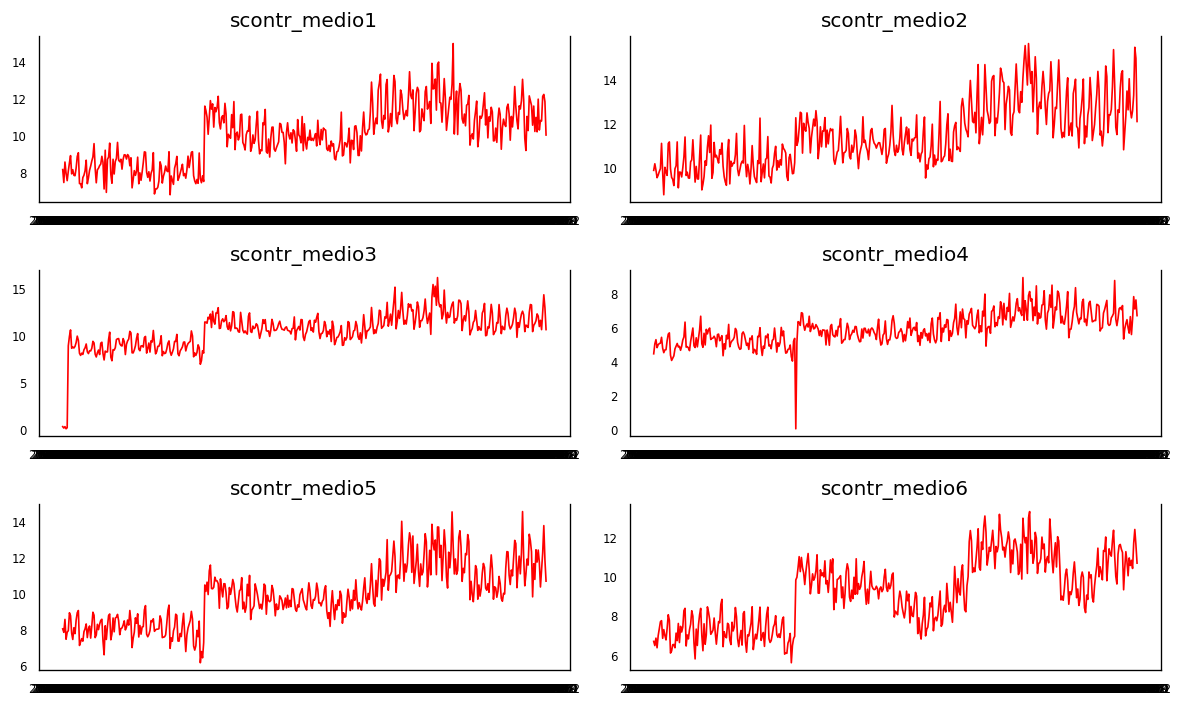

In [13]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=7)

plt.tight_layout();

### Testing Causation using Granger’s Causality Test

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,scontr_medio1_x,scontr_medio2_x,scontr_medio3_x,scontr_medio4_x,scontr_medio5_x,scontr_medio6_x
scontr_medio1_y,1.0000,0.0,0.0000,0.0001,0.0,0.0
scontr_medio2_y,0.0000,1.0,0.0000,0.0000,0.0,0.0
scontr_medio3_y,0.0000,0.0,1.0000,0.0000,0.0,0.0
scontr_medio4_y,0.0000,0.0,0.0000,1.0000,0.0,0.0
scontr_medio5_y,0.0161,0.0,0.0001,0.0000,1.0,0.0
scontr_medio6_y,0.0001,0.0,0.0000,0.0000,0.0,1.0


### Cointegration Test

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
scontr_medio1 ::  249.41    > 83.9383   =>   True
scontr_medio2 ::  120.2     > 60.0627   =>   True
scontr_medio3 ::  61.78     > 40.1749   =>   True
scontr_medio4 ::  32.65     > 24.2761   =>   True
scontr_medio5 ::  10.08     > 12.3212   =>   False
scontr_medio6 ::  0.28      > 4.1296    =>   False


Procedo con solo 4 ristoranti

In [28]:
df=df[['scontr_medio1','scontr_medio2','scontr_medio3','scontr_medio4']]

In [29]:
nobs = 15
df_train, df_test = df[0:-nobs], df[-nobs:]

### Check for Stationarity and Make the Time Series Stationary

In [30]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

Call the adfuller_test() on each series.

In [31]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "scontr_medio1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4649
 No. Lags Chosen       = 13
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.5508. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "scontr_medio2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.066
 No. Lags Chosen       = 14
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.7284. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "scontr_medio3" 
    -----------------------------------------------
 Null 

The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.

In [32]:
# 1st difference
df_differenced = df_train.diff().dropna()

Re-run ADF test on each differenced series.

In [33]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "scontr_medio1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9371
 No. Lags Chosen       = 12
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "scontr_medio2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7028
 No. Lags Chosen       = 13
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "scontr_medio3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

### How to Select the Order (P) of VAR model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC

In [34]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\marta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -2.3072630785299473
BIC :  -2.113480133325079
FPE :  0.09953375481867134
HQIC:  -2.2306418625571856 

Lag Order = 2
AIC :  -2.614411514643268
BIC :  -2.2649704863822917
FPE :  0.07321285138718413
HQIC:  -2.476230245110117 

Lag Order = 3
AIC :  -2.6949341578376176
BIC :  -2.1892698326228435
FPE :  0.06755240961618486
HQIC:  -2.494957431482596 

Lag Order = 4
AIC :  -2.8637678039675762
BIC :  -2.201311541688278
FPE :  0.05706401135277492
HQIC:  -2.601758770565719 

Lag Order = 5
AIC :  -3.4882432709401128
BIC :  -2.6684229764125393
FPE :  0.030565309513105512
HQIC:  -3.163963621121432 

Lag Order = 6
AIC :  -3.881009035589089
BIC :  -2.9032491293856255
FPE :  0.02064241075759221
HQIC:  -3.4942189885270762 

Lag Order = 7
AIC :  -4.072443905900488
BIC :  -2.93616529486388
FPE :  0.01705183574630946
HQIC:  -3.6229021968689663 

Lag Order = 8
AIC :  -4.093208992601859
BIC :  -2.7978290400403676
FPE :  0.016709083079081397
HQIC:  -3.5806728603984994 

Lag Order = 9
AIC 

In the above output, the AIC drops to lowest at lag 8, then increases at lag 5 and then continuously drops further.

Let’s go with the lag 7 model.

### Train the VAR Model of Selected Order(p)

In [35]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Jun, 2021
Time:                     20:15:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -2.79783
Nobs:                     409.000    HQIC:                  -3.58067
Log likelihood:          -1352.32    FPE:                  0.0167091
AIC:                     -4.09321    Det(Omega_mle):       0.0122506
--------------------------------------------------------------------
Results for equation scontr_medio1
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.016511         0.035264            0.468           0.640
L1.scontr_medio1        -0.766223         0.064774          -11.829           0.000
L1.scontr_medio2         0.032390       

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [36]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

scontr_medio1 : 1.99
scontr_medio2 : 2.02
scontr_medio3 : 2.01
scontr_medio4 : 2.04


### How to Forecast VAR model using statsmodels

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [37]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 7

8


In [38]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 0.4418459 ,  1.02765252,  0.61504497,  0.11341852],
       [ 1.16260215,  1.67717481,  0.30560092,  0.15219711],
       [-1.10122219, -1.59688461, -0.387539  ,  1.94323661],
       [-2.09078083, -1.90872976, -1.79052892, -2.28419252],
       [-0.65458042, -0.33470767,  0.68909763, -0.38368016],
       [ 1.84289969,  1.1212382 , -0.05565366,  0.42487551],
       [-0.76672065, -0.11721554, -0.18827914,  0.57403283],
       [ 1.87504928,  1.11244235,  1.60263628,  0.07213868]])

forecast.

In [39]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,scontr_medio1_1d,scontr_medio2_1d,scontr_medio3_1d,scontr_medio4_1d
date,,,,
2021-03-27,0.190491,1.059205,0.976447,0.314912
2021-03-28,-0.837714,-1.296059,-1.369255,-0.185178
2021-03-29,-1.149974,-1.051034,-1.338645,-0.742025
2021-03-30,-0.225923,-0.226709,-0.002499,-0.131335
2021-03-31,0.953821,0.657214,0.823981,0.443060
2021-04-01,-0.091138,-0.003811,-0.010355,0.070755
2021-04-02,0.710775,1.045718,0.912832,0.478037
2021-04-03,0.445894,0.473912,0.542449,0.170629
2021-04-06,-0.923740,-1.070308,-1.261710,-0.499479


Invert the transformation to get the real forecast

In [40]:
def invert_transformation(df_train, df_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [41]:
df_results = invert_transformation(df_train, df_forecast, first_diff=True) 

In [42]:
df_results

,scontr_medio1_1d,scontr_medio2_1d,scontr_medio3_1d,scontr_medio4_1d,scontr_medio1_forecast,scontr_medio2_forecast,scontr_medio3_forecast,scontr_medio4_forecast
date,,,,,,,,
2021-03-27,0.190491,1.059205,0.976447,0.314912,12.316449,14.645758,13.382430,7.483752
2021-03-28,-0.837714,-1.296059,-1.369255,-0.185178,11.478735,13.349699,12.013175,7.298574
2021-03-29,-1.149974,-1.051034,-1.338645,-0.742025,10.328761,12.298665,10.674530,6.556549
2021-03-30,-0.225923,-0.226709,-0.002499,-0.131335,10.102838,12.071955,10.672031,6.425214
2021-03-31,0.953821,0.657214,0.823981,0.443060,11.056659,12.729169,11.496012,6.868275
2021-04-01,-0.091138,-0.003811,-0.010355,0.070755,10.965521,12.725358,11.485657,6.939030
2021-04-02,0.710775,1.045718,0.912832,0.478037,11.676296,13.771076,12.398489,7.417067
2021-04-03,0.445894,0.473912,0.542449,0.170629,12.122189,14.244988,12.940939,7.587697
2021-04-06,-0.923740,-1.070308,-1.261710,-0.499479,11.198449,13.174680,11.679229,7.088218


In [43]:
df_results.loc[:, ['scontr_medio1_forecast', 'scontr_medio2_forecast', 'scontr_medio3_forecast', 'scontr_medio4_forecast']]

,scontr_medio1_forecast,scontr_medio2_forecast,scontr_medio3_forecast,scontr_medio4_forecast
date,,,,
2021-03-27,12.316449,14.645758,13.382430,7.483752
2021-03-28,11.478735,13.349699,12.013175,7.298574
2021-03-29,10.328761,12.298665,10.674530,6.556549
2021-03-30,10.102838,12.071955,10.672031,6.425214
2021-03-31,11.056659,12.729169,11.496012,6.868275
2021-04-01,10.965521,12.725358,11.485657,6.939030
2021-04-02,11.676296,13.771076,12.398489,7.417067
2021-04-03,12.122189,14.244988,12.940939,7.587697
2021-04-06,11.198449,13.174680,11.679229,7.088218


### Plot of Forecast vs Actuals

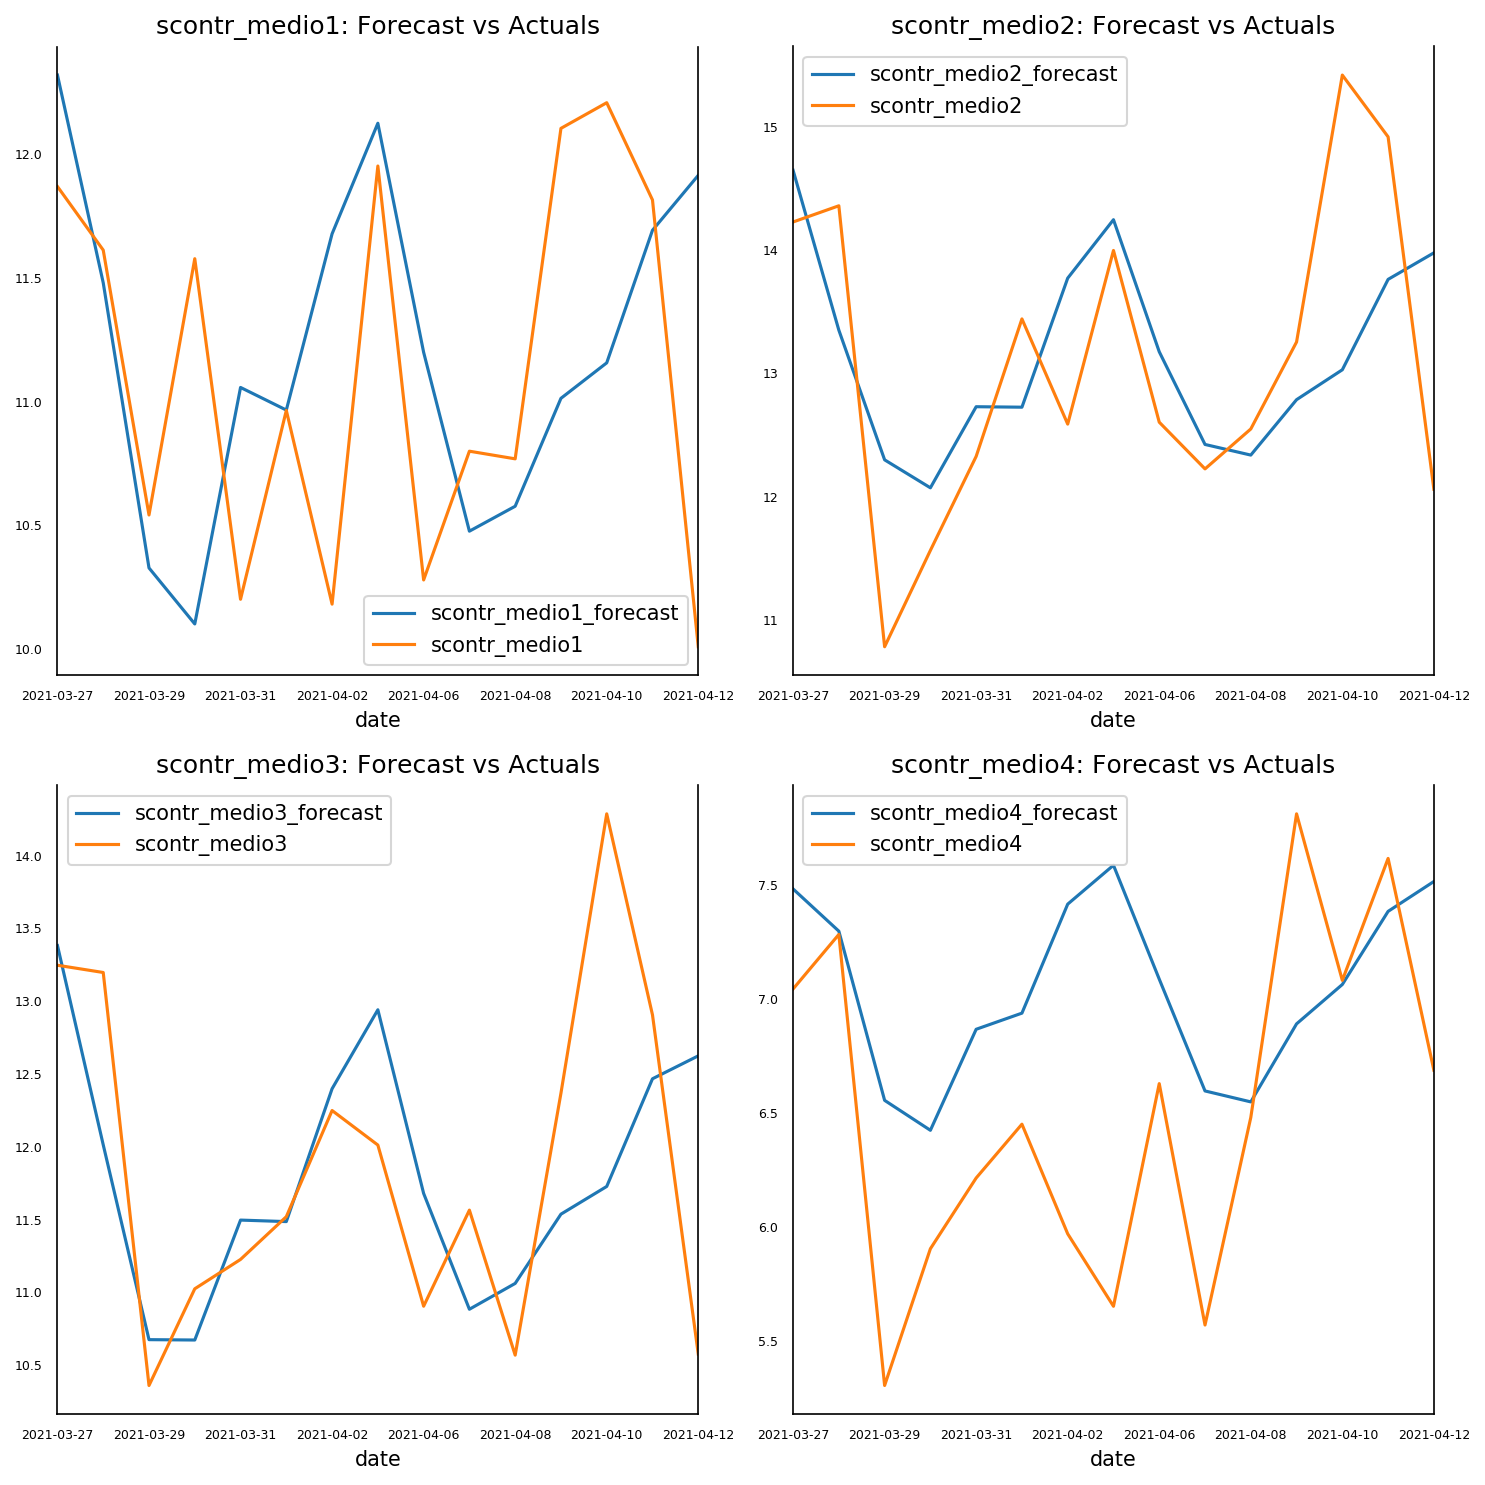

In [44]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluate the Forecasts

To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [47]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    #mape = np.mean(np.abs((actual-forecast)/np.abs(actual)))*100 #MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: scontr.1')
accuracy_prod = forecast_accuracy(df_results['scontr_medio1_forecast'].values, df_test['scontr_medio1'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: scontr.2')
accuracy_prod = forecast_accuracy(df_results['scontr_medio2_forecast'].values, df_test['scontr_medio2'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: scontr.3')
accuracy_prod = forecast_accuracy(df_results['scontr_medio3_forecast'].values, df_test['scontr_medio3'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: scontr.4')
accuracy_prod = forecast_accuracy(df_results['scontr_medio4_forecast'].values, df_test['scontr_medio4'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: scontr.1
mape :  0.0637
me :  0.0799
mae :  0.6922
mpe :  0.0113
rmse :  0.9065
corr :  0.1698
minmax :  0.0594

Forecast Accuracy of: scontr.2
mape :  0.0658
me :  0.0677
mae :  0.8604
mpe :  0.0114
rmse :  1.0713
corr :  0.5239
minmax :  0.0622

Forecast Accuracy of: scontr.3
mape :  0.062
me :  -0.0643
mae :  0.7465
mpe :  0.0001
rmse :  1.018
corr :  0.4828
minmax :  0.0589

Forecast Accuracy of: scontr.4
mape :  0.1127
me :  0.5301
mae :  0.6863
mpe :  0.0926
rmse :  0.8709
corr :  0.3604
minmax :  0.0959
